In [1]:
# %load cyclegan_train.py
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from models import Generator
from models import Discriminator
from utils import ReplayBuffer
from utils import weights_init_normal

import time

In [2]:
start_time = time.time()

if not os.path.exists('ckpt'):
    os.makedirs('output/animation')

# parameters
#TODO : set up all the parameters
epochs =  150   # number of epochs of training
batchsize = 100    # size of the batches
animation_root = './animation'    # root directory of the dataset
cartoon_root = './cartoon'    # root directory of the dataset
lr = 1e-4    # initial learning rate
size = 32    # size of the data crop (squared assumed)
input_nc = 3     # number of channels of input data
output_nc = 3    # number of channels of output data

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

###### Definition of variables ######
# Networks
netG_A2B = Generator(input_nc, output_nc)
netG_B2A = Generator(output_nc, input_nc)
netD_A = Discriminator(input_nc)
netD_B = Discriminator(output_nc)

netG_A2B.to(device)
netG_B2A.to(device)
netD_A.to(device)
netD_B.to(device)

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr*0.5, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr*0.5, betas=(0.5, 0.999))

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
input_A = Tensor(batchsize, input_nc, size, size)
input_B = Tensor(batchsize, output_nc, size, size)
target_real = Variable(Tensor(batchsize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batchsize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
animation_set = torchvision.datasets.ImageFolder(animation_root, transform) 
cartoon_set = torchvision.datasets.ImageFolder(cartoon_root, transform) 
animation_loader = torch.utils.data.DataLoader(dataset=animation_set,batch_size=batchsize,shuffle=True)
cartoon_loader = torch.utils.data.DataLoader(dataset=cartoon_set,batch_size=batchsize,shuffle=True)
###################################
G_loss  = []
DA_loss  = []
DB_loss  = []

/home/john/Course/Deep_learning/HW3/DL_HW3/utils.py:44: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.weight.data, 0.0, 0.02)


In [3]:
###### Training ######
for epoch in range(1, epochs):
    i=1
    print('epoch',epoch)
    for batch in zip(animation_loader, cartoon_loader):
        # Set model input
        A = torch.FloatTensor(batch[0][0])
        B = torch.FloatTensor(batch[1][0])
        real_A = Variable(input_A.copy_(A))
        real_B = Variable(input_B.copy_(B))
        

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()
        # TODO : calculate the loss for the generators, and assign to loss_G
        
        # 1. Identity loss
        # identity mapping: 希望在轉換的時候保留大部分的色調，也就是轉換後的改變不要那麼大
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B) * 5.0
        
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A) * 5.0
        
        # 2. GAN loss
        # 希望能夠產生出disciminator分不出來的圖片，判斷predict和target的loss越小越好
        fake_B = netG_A2B(real_A)
        predict_fake = netD_B(fake_B)
        #print(predict_fake.squeeze().shape, target_real.shape)
        loss_GAN_A2B = criterion_GAN(predict_fake.squeeze(), target_real)
        
        fake_A = netG_B2A(real_B)
        predict_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(predict_fake.squeeze(), target_real)
        
        # 3. Cycle loss
        # 希望產生的圖片也能夠很好的還原回來
        # 如果沒有這個loss，generator會傾向全部都生成另一類的某張圖片就好
        recover_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recover_A, real_A) * 10.0
        
        recover_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recover_B, real_B) * 10.0
        
        # sum
        loss_G = loss_identity_B + loss_identity_A + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()
        # 希望能夠把real和fake分出來
        # TODO : calculate the loss for a discriminator, and assign to loss_D_A
        predict_real = netD_A(real_A)
        loss_D_real = criterion_GAN(predict_real.squeeze(), target_real)
        
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        predict_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(predict_fake.squeeze(), target_fake)
        
        #sum
        loss_D_A = (loss_D_real + loss_D_fake) * 0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()
        # TODO : calculate the loss for the other discriminator, and assign to loss_D_B
        predict_real = netD_B(real_B)
        loss_D_real = criterion_GAN(predict_real.squeeze(), target_real)
        
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        predict_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(predict_fake.squeeze(), target_fake)
        
        #sum
        loss_D_B = (loss_D_real + loss_D_fake) * 0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################
        
        G_loss.append(loss_G.data[0])
        DA_loss.append(loss_D_A.data[0])
        DB_loss.append(loss_D_B.data.data[0])
        # Progress report
        if (i%10==0):
            print("loss_G : ",loss_G.data.cpu().numpy() ,",loss_D:", (loss_D_A.data.cpu().numpy() + loss_D_B.data.cpu().numpy()))
            i=0
        i=i+1
    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), 'ckpt/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), 'ckpt/netG_B2A.pth')
    torch.save(netD_A.state_dict(), 'ckpt/netD_A.pth')
    torch.save(netD_B.state_dict(), 'ckpt/netD_B.pth')
    
end_time = time.time()
print('Total cost time',time.strftime("%H hr %M min %S sec", time.gmtime(end_time - start_time)))

# TODO : plot the figure


epoch 1


/usr/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:90: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


loss_G :  14.6407585 ,loss_D: 0.78371835
loss_G :  10.502541 ,loss_D: 0.9055632
loss_G :  10.057884 ,loss_D: 1.3246768
loss_G :  11.930872 ,loss_D: 0.6639138
loss_G :  8.591702 ,loss_D: 0.6199968
loss_G :  8.203316 ,loss_D: 0.62059605
loss_G :  8.012879 ,loss_D: 0.7694259
loss_G :  8.53537 ,loss_D: 0.48837465
loss_G :  7.9071107 ,loss_D: 0.5616041
loss_G :  7.586134 ,loss_D: 0.5614047
epoch 2
loss_G :  8.005066 ,loss_D: 0.47616696
loss_G :  7.4930587 ,loss_D: 0.6282731
loss_G :  7.0912447 ,loss_D: 0.5722857
loss_G :  7.4883785 ,loss_D: 0.4664913
loss_G :  7.474785 ,loss_D: 0.5129374
loss_G :  7.043111 ,loss_D: 0.4638353
loss_G :  6.7513494 ,loss_D: 0.5995549
loss_G :  6.827491 ,loss_D: 0.59469306
loss_G :  6.750361 ,loss_D: 0.5676883
loss_G :  6.2989316 ,loss_D: 0.45798612
epoch 3
loss_G :  6.594182 ,loss_D: 0.4578038
loss_G :  6.22223 ,loss_D: 0.49342597
loss_G :  6.6994705 ,loss_D: 0.47246343
loss_G :  6.4557347 ,loss_D: 0.46302637
loss_G :  6.443211 ,loss_D: 0.4662881
loss_G :  6.31

loss_G :  4.4504056 ,loss_D: 0.3664435
loss_G :  4.625757 ,loss_D: 0.41734213
loss_G :  3.848372 ,loss_D: 0.40700388
loss_G :  4.190563 ,loss_D: 0.35882092
loss_G :  3.819466 ,loss_D: 0.36657053
epoch 23
loss_G :  4.455724 ,loss_D: 0.42200282
loss_G :  4.2005973 ,loss_D: 0.42044806
loss_G :  4.111512 ,loss_D: 0.37187353
loss_G :  3.8583708 ,loss_D: 0.4469617
loss_G :  4.3811994 ,loss_D: 0.3898971
loss_G :  4.023596 ,loss_D: 0.4054331
loss_G :  3.887182 ,loss_D: 0.37667155
loss_G :  4.4796734 ,loss_D: 0.3656473
loss_G :  4.3132224 ,loss_D: 0.36164024
loss_G :  4.3347473 ,loss_D: 0.3965224
epoch 24
loss_G :  4.117898 ,loss_D: 0.4008311
loss_G :  4.441299 ,loss_D: 0.3539096
loss_G :  4.194649 ,loss_D: 0.3712657
loss_G :  4.1859736 ,loss_D: 0.39255697
loss_G :  4.101895 ,loss_D: 0.3516861
loss_G :  4.0729265 ,loss_D: 0.34218448
loss_G :  4.2359157 ,loss_D: 0.35707307
loss_G :  3.7227101 ,loss_D: 0.38851216
loss_G :  3.941009 ,loss_D: 0.38317946
loss_G :  3.871257 ,loss_D: 0.36625424
epoch 

loss_G :  3.5379753 ,loss_D: 0.33926463
epoch 43
loss_G :  4.0494146 ,loss_D: 0.3793849
loss_G :  3.2788534 ,loss_D: 0.38279435
loss_G :  3.3123665 ,loss_D: 0.3652865
loss_G :  3.7827744 ,loss_D: 0.36394125
loss_G :  3.4132366 ,loss_D: 0.36530918
loss_G :  3.3833132 ,loss_D: 0.36532214
loss_G :  3.4883404 ,loss_D: 0.341198
loss_G :  3.8245234 ,loss_D: 0.3287835
loss_G :  3.7980485 ,loss_D: 0.40435612
loss_G :  4.063524 ,loss_D: 0.34509668
epoch 44
loss_G :  3.375766 ,loss_D: 0.34127834
loss_G :  3.7474806 ,loss_D: 0.365919
loss_G :  13.447816 ,loss_D: 5.7812076
loss_G :  3.7985742 ,loss_D: 0.3802682
loss_G :  3.7841802 ,loss_D: 0.41345665
loss_G :  3.5476956 ,loss_D: 0.39888012
loss_G :  3.4795291 ,loss_D: 0.43742776
loss_G :  3.3262644 ,loss_D: 0.42468226
loss_G :  3.3892038 ,loss_D: 0.4464069
loss_G :  3.473115 ,loss_D: 0.447809
epoch 45
loss_G :  3.4297814 ,loss_D: 0.4500507
loss_G :  3.2779486 ,loss_D: 0.419681
loss_G :  3.4862604 ,loss_D: 0.37873173
loss_G :  3.1828053 ,loss_D: 0.

loss_G :  3.2253563 ,loss_D: 0.35142246
loss_G :  3.1320417 ,loss_D: 0.3736354
loss_G :  3.5562313 ,loss_D: 0.3807876
loss_G :  3.3720913 ,loss_D: 0.3168709
loss_G :  3.2294617 ,loss_D: 0.37418306
loss_G :  2.904574 ,loss_D: 0.4213708
loss_G :  3.1339128 ,loss_D: 0.3766412
epoch 64
loss_G :  2.938711 ,loss_D: 0.44139165
loss_G :  3.1970725 ,loss_D: 0.37740856
loss_G :  3.0966697 ,loss_D: 0.3635888
loss_G :  3.3471532 ,loss_D: 0.36943674
loss_G :  3.2964501 ,loss_D: 0.35115188
loss_G :  3.0343645 ,loss_D: 0.44833785
loss_G :  3.4244604 ,loss_D: 0.353201
loss_G :  3.4255636 ,loss_D: 0.3839079
loss_G :  3.505116 ,loss_D: 0.38998908
loss_G :  3.0793326 ,loss_D: 0.4668495
epoch 65
loss_G :  3.244084 ,loss_D: 0.3498434
loss_G :  3.2653868 ,loss_D: 0.3476215
loss_G :  3.4304996 ,loss_D: 0.37279218
loss_G :  3.3310008 ,loss_D: 0.3693585
loss_G :  3.19651 ,loss_D: 0.36520892
loss_G :  3.2996578 ,loss_D: 0.3680801
loss_G :  2.9804235 ,loss_D: 0.47221994
loss_G :  3.109891 ,loss_D: 0.3832901
loss

loss_G :  3.1351156 ,loss_D: 0.3366267
loss_G :  3.041099 ,loss_D: 0.39718863
loss_G :  3.1639023 ,loss_D: 0.3721962
epoch 84
loss_G :  3.1621873 ,loss_D: 0.33753565
loss_G :  2.93077 ,loss_D: 0.34924343
loss_G :  3.0210528 ,loss_D: 0.36575925
loss_G :  2.9877067 ,loss_D: 0.37510723
loss_G :  3.2395282 ,loss_D: 0.34486377
loss_G :  3.2019935 ,loss_D: 0.352996
loss_G :  3.15602 ,loss_D: 0.37016338
loss_G :  3.1786323 ,loss_D: 0.33685875
loss_G :  3.0478287 ,loss_D: 0.31709093
loss_G :  2.8689308 ,loss_D: 0.3979936
epoch 85
loss_G :  3.1356897 ,loss_D: 0.34109056
loss_G :  3.019917 ,loss_D: 0.34069055
loss_G :  2.9253602 ,loss_D: 0.36372596
loss_G :  3.546277 ,loss_D: 0.31181717
loss_G :  3.014913 ,loss_D: 0.35663158
loss_G :  3.3467326 ,loss_D: 0.3538691
loss_G :  3.2151985 ,loss_D: 0.40605718
loss_G :  2.9979227 ,loss_D: 0.35344824
loss_G :  3.0188155 ,loss_D: 0.36245105
loss_G :  3.1573646 ,loss_D: 0.36355558
epoch 86
loss_G :  2.932862 ,loss_D: 0.37858197
loss_G :  3.2455204 ,loss_D:

loss_G :  2.8222785 ,loss_D: 0.34873712
loss_G :  2.929381 ,loss_D: 0.31741464
loss_G :  3.019242 ,loss_D: 0.33705384
loss_G :  2.816619 ,loss_D: 0.3355673
loss_G :  2.8749077 ,loss_D: 0.3578033
loss_G :  2.9589763 ,loss_D: 0.33416486
loss_G :  2.8690653 ,loss_D: 0.40253705
loss_G :  2.6705446 ,loss_D: 0.42264345
loss_G :  2.767896 ,loss_D: 0.46026123
loss_G :  2.6735563 ,loss_D: 0.4191936
epoch 105
loss_G :  2.7596235 ,loss_D: 0.42613623
loss_G :  2.7396522 ,loss_D: 0.41801623
loss_G :  2.857968 ,loss_D: 0.4122619
loss_G :  2.806346 ,loss_D: 0.38719705
loss_G :  2.9408355 ,loss_D: 0.38611943
loss_G :  2.7127857 ,loss_D: 0.35313866
loss_G :  2.7692022 ,loss_D: 0.39408582
loss_G :  3.0598388 ,loss_D: 0.37431958
loss_G :  2.8558016 ,loss_D: 0.36872834
loss_G :  3.315129 ,loss_D: 0.41005537
epoch 106
loss_G :  2.968128 ,loss_D: 0.32645786
loss_G :  2.8009396 ,loss_D: 0.36922082
loss_G :  2.908801 ,loss_D: 0.3546819
loss_G :  2.7076037 ,loss_D: 0.33935553
loss_G :  3.0741189 ,loss_D: 0.326

loss_G :  2.75138 ,loss_D: 0.35508126
loss_G :  3.0515547 ,loss_D: 0.33801293
loss_G :  3.233491 ,loss_D: 0.35002074
loss_G :  2.9769871 ,loss_D: 0.33868608
loss_G :  3.0218582 ,loss_D: 0.31069687
loss_G :  2.4629345 ,loss_D: 0.44590676
loss_G :  2.9382434 ,loss_D: 0.3606322
epoch 125
loss_G :  2.8590188 ,loss_D: 0.31062108
loss_G :  3.051324 ,loss_D: 0.33194798
loss_G :  2.7302642 ,loss_D: 0.35981023
loss_G :  3.0941484 ,loss_D: 0.3196504
loss_G :  2.799619 ,loss_D: 0.33706254
loss_G :  3.1226957 ,loss_D: 0.36298773
loss_G :  4.383205 ,loss_D: 0.45167416
loss_G :  2.6935313 ,loss_D: 0.35084528
loss_G :  3.077282 ,loss_D: 0.34408724
loss_G :  2.7325373 ,loss_D: 0.36740625
epoch 126
loss_G :  2.654611 ,loss_D: 0.34324637
loss_G :  3.0263028 ,loss_D: 0.29572466
loss_G :  3.6191082 ,loss_D: 0.3089475
loss_G :  3.1669545 ,loss_D: 0.27711618
loss_G :  3.091892 ,loss_D: 0.29558474
loss_G :  2.8289685 ,loss_D: 0.32713914
loss_G :  3.2464585 ,loss_D: 0.27152836
loss_G :  2.8263385 ,loss_D: 0.3

loss_G :  2.7047071 ,loss_D: 0.32518402
loss_G :  2.8072226 ,loss_D: 0.3300093
loss_G :  2.644197 ,loss_D: 0.33665073
loss_G :  3.207394 ,loss_D: 0.3527476
epoch 145
loss_G :  2.8799205 ,loss_D: 0.29480994
loss_G :  2.9628987 ,loss_D: 0.2872246
loss_G :  2.7806976 ,loss_D: 0.3317534
loss_G :  3.098342 ,loss_D: 0.30101746
loss_G :  3.0548532 ,loss_D: 0.30879703
loss_G :  2.6527472 ,loss_D: 0.32268286
loss_G :  2.88005 ,loss_D: 0.32162595
loss_G :  3.530782 ,loss_D: 0.38623095
loss_G :  2.9349349 ,loss_D: 0.3320489
loss_G :  2.7024987 ,loss_D: 0.30924478
epoch 146
loss_G :  2.9734585 ,loss_D: 0.27795857
loss_G :  3.0074446 ,loss_D: 0.2802509
loss_G :  3.3845325 ,loss_D: 0.28840914
loss_G :  3.0351744 ,loss_D: 0.36191452
loss_G :  2.7625418 ,loss_D: 0.38218588
loss_G :  2.9070408 ,loss_D: 0.2988885
loss_G :  2.9250424 ,loss_D: 0.29150605
loss_G :  2.9001446 ,loss_D: 0.31565207
loss_G :  3.0794463 ,loss_D: 0.3482073
loss_G :  2.7943995 ,loss_D: 0.34668586
epoch 147
loss_G :  3.178701 ,loss

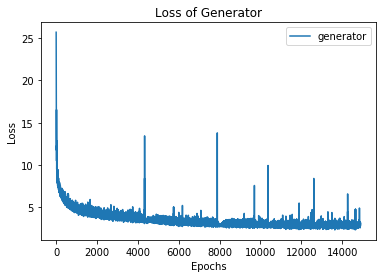

In [8]:
plt.title('Loss of Generator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(G_loss, label = 'generator')
plt.legend(loc=1)

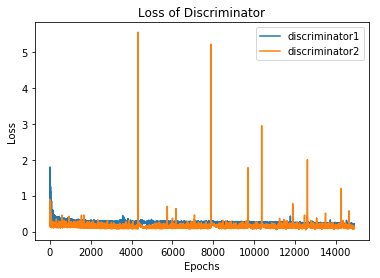

In [10]:
plt.title('Loss of Discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(DA_loss, label = 'discriminator1')
plt.plot(DB_loss, label = 'discriminator2')
plt.legend(loc=1)